In [1820]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle

# Add the path to the library folder
sys.path.append('./lib')

from model import PDFmodel

In [1821]:
seed = 12312

In [1822]:
# Load data
fk_grid = np.load('Tommaso/fk_grid.npy')
real_data = np.load('Tommaso/data.npy')
FK = np.load('Tommaso/FK.npy')
f_bcdms = np.load('Tommaso/f_bcdms.npy')
Cy = np.load('Tommaso/Cy.npy')
Cinv = np.linalg.inv(Cy)
data = FK @ f_bcdms

In [1872]:
# Generate model
model = PDFmodel(
        dense_layer='Dense',
        input=fk_grid,
        outputs=1,
        architecture=[28,20],
        activations=['tanh', 'tanh'],
        kernel_initializer='GlorotNormal',
        user_ki_args=None,
        seed=seed)

f0 = model.predict().numpy().reshape(-1)

# Compute ntk
ntk = model.compute_ntk()

In [1930]:
reg1 = 1e4 # Integrability
reg2 = 1e4 # At one
reg3 = 1e4 # At zero
mat_reg_2 = np.zeros((FK.shape[1], FK.shape[1]))
mat_reg_3 = np.zeros((FK.shape[1], FK.shape[1]))
mat_reg_2[-1,-1] = 1
mat_reg_3[0,0] = 1
M = FK.T @ Cinv @ FK + reg1 * np.eye(FK.shape[1]) + reg2 * mat_reg_2 + reg3 * mat_reg_3
U_M, sigma, Vh_M = np.linalg.svd(M, hermitian=True)

In [1931]:
for r_idx in range(U_M.shape[0]):
  if not np.allclose(U_M[:,r_idx], Vh_M.T[:,r_idx]):
    print(f"Noise at {r_idx}")

In [1932]:
r = 20 # Number of singular values to keep
print(np.allclose(U_M[:,r-1], Vh_M.T[:,r-1]))
u = U_M
u_tilde = u @ np.diag(np.sqrt(sigma))

True


In [1933]:
H_tilde = np.zeros((r,r))
for i in range(r):
    for j in range(r):
        H_tilde[i,j] = np.dot(u_tilde[:,i], ntk.numpy() @ u_tilde[:,j])

U_h_tilde, h, Vh_h_tilde = np.linalg.svd(H_tilde, hermitian=True)

In [1934]:
for l_idx in range(U_h_tilde.shape[0]):
  if not np.allclose(U_h_tilde[:,l_idx], Vh_h_tilde.T[:,l_idx]):
    print(f"Noise at {l_idx + 1}")

Noise at 5
Noise at 7
Noise at 11
Noise at 13
Noise at 14
Noise at 15
Noise at 17


In [1935]:
l = 4 # Number of singular values to keep
print(np.allclose(U_h_tilde[:, l-1], Vh_h_tilde.T[:, l-1]))
z = U_h_tilde

True


In [1936]:
b = ntk.numpy() @ FK.T @ Cinv @ data
b_tilde = np.array([np.dot(u[:, i], b) for i in range(r)])
B = np.array([np.dot(z[:,n], b_tilde) for n in range(l)])

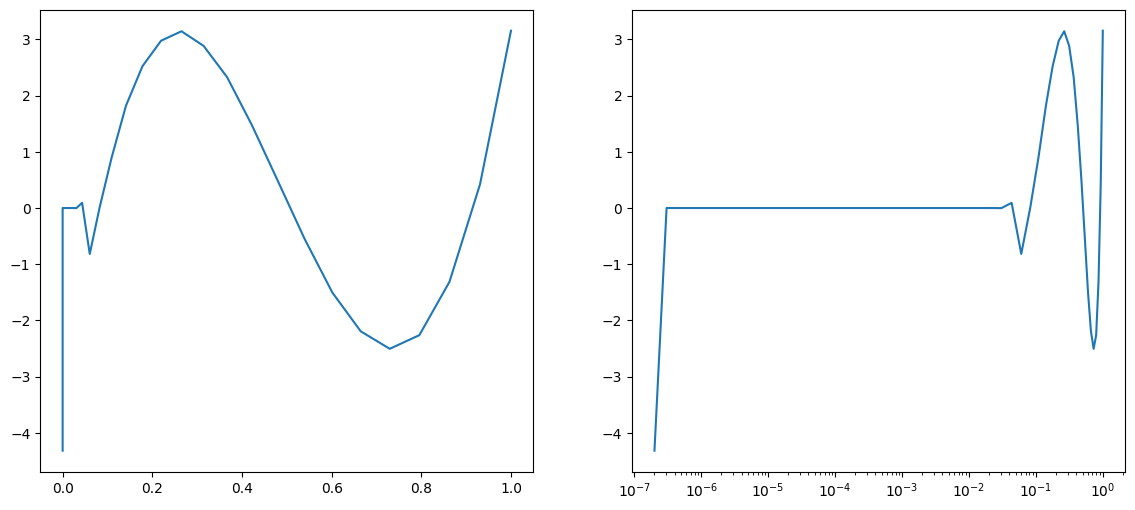

In [1937]:
inf_res = [B[n] / h[n] for n in range(l)]
inf_tilde = np.sum([z[:,n] * inf_res[n] for n in range(l)], axis=0)
f_inf = np.sum([inf_tilde[i] * u_tilde[:,i] / sigma[i] for i in range(r)], axis=0)

fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].plot(fk_grid, f_inf)
axs[1].plot(fk_grid, f_inf)
axs[1].set_xscale('log')

In [1938]:
f0_tilde = np.array([np.dot(u_tilde[:,i], f0) for i in range(r)])
F0 = np.array([np.dot(z[:,n], f0_tilde) for n in range(l)])

def Ft(t):
  ret = [
    np.exp(-h[n] * t) * F0[n] +
    ( 1 - np.exp(-h[n] * t) ) * B[n] / h[n]
    for n in range(l)
  ]
  return np.array(ret)

def ft_tilde(t):
  F = Ft(t)
  ret = [F[n] * z[:,n] for n in range(l)]
  return np.sum(ret, axis=0)

def ft(t):
  f_tilde = ft_tilde(t)
  ret = [f_tilde[i] * u_tilde[:,i] / sigma[i] for i in range(r)]
  return np.sum(ret, axis=0)

In [1939]:
f0_tilde = np.array([np.dot(u_tilde[:,i], f0) for i in range(r)])
f0_rec = [f0_tilde[i] * u_tilde[:,i] / sigma[i] for i in range(r)]
f0_rec = np.sum(f0_rec, axis=0)

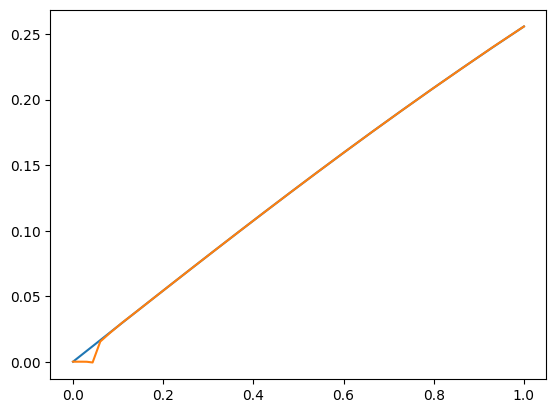

In [1940]:
plt.plot(fk_grid, f0, label='f0')
plt.plot(fk_grid, f0_rec, label='ft(0)')
#plt.xscale('log')

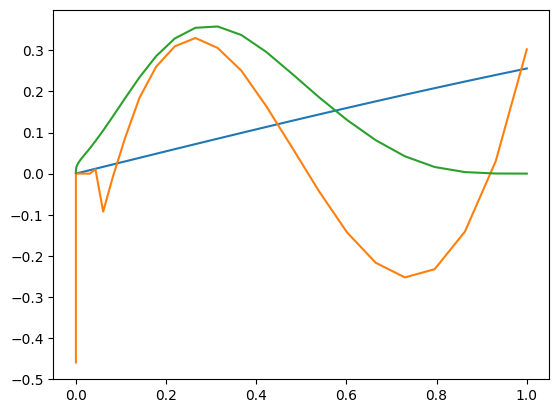

In [1945]:
plt.plot(fk_grid, f0, label='f0')
plt.plot(fk_grid, ft(5e-2), label='ft(0)')
plt.plot(fk_grid, f_bcdms)
#plt.xscale('log')

# 